# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

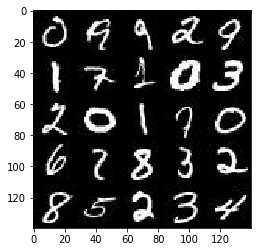

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

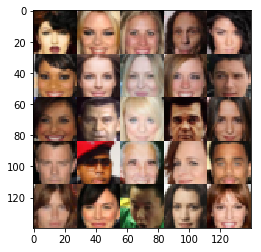

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [16]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/envs/dl/

### Leaky ReLU

In [6]:
def lrelu(h, alpha=0.2):
    return tf.maximum(alpha * h, h)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [28]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    strides = (2, 2)
    kernel_size = (4, 4)
        
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3(1)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME', activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = lrelu(x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='SAME', activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = lrelu(bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='SAME', activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = lrelu(bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        
        
        
        
#         # Input layer is 28x28x3(1)
#         x1 = tf.layers.conv2d(images, 128, 5, strides=1, padding='SAME')
#         relu1 = lrelu(x1)
#         # 28x28x128
        
#         x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='SAME')
#         bn2 = tf.layers.batch_normalization(x2, training=True)
#         relu2 = lrelu(bn2)
#         # 14x14x256
        
#         x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='SAME')
#         bn3 = tf.layers.batch_normalization(x3, training=True)
#         relu3 = lrelu(bn3)
#         # 7x7x512
        
#         # Flatten it
#         flat = tf.reshape(relu3, (-1, 7*7*512))
#         logits = tf.layers.dense(flat, 1)
#         out = tf.sigmoid(logits)
        
        
        
#         conv1 = tf.layers.conv2d(inputs = images, 
#                                  filters = 64, 
#                                  strides=(1,1), 
#                                  kernel_size=kernel_size, 
#                                  padding='SAME')
#         conv1 = tf.layers.batch_normalization(conv1, training=True)
#         conv1 = lrelu(conv1)
#         # Now 28x28x64        
        
#         conv2 = tf.layers.conv2d(inputs = conv1,
#                                  filters = 128,
#                                  strides=strides, 
#                                  kernel_size=kernel_size, 
#                                  padding='SAME')
#         conv2 = tf.layers.batch_normalization(conv2, training=True)
#         conv2 = lrelu(conv2)
#         # Now 14x14x128
        
#         conv3 = tf.layers.conv2d(inputs = conv2,
#                                  filters = 256,
#                                  strides=strides, 
#                                  kernel_size=kernel_size, 
#                                  padding='SAME')
#         conv3 = tf.layers.batch_normalization(conv3, training=True)
#         conv3 = lrelu(conv3)
#         # Now 8x8x256
        
#         conv4 = tf.layers.conv2d(inputs = conv3,
#                                  filters = 512,
#                                  strides=strides, 
#                                  kernel_size=kernel_size, 
#                                  padding='SAME')
#         conv4 = tf.layers.batch_normalization(conv4, training=True)
#         conv4 = lrelu(conv4)
    
# #         print(conv1)
# #         print(conv2)
# #         print(conv3)
# #         print(conv4)
        
#         # Fully Connected layer
#         logits = tf.layers.dense(tf.reshape(conv4, [-1, 4*4*512]), 1, activation=None)
#         out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [29]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    strides = (2, 2)
    kernel_size = (4, 4)
    
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # Fully connected layer
        x1 = tf.layers.dense(z, 7*7*512, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = lrelu(x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='SAME', activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = lrelu(x2)
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='SAME', activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = lrelu(x3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='SAME', activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3(1)
        
        out = tf.tanh(logits)
        
        
        
        
        
#         full = tf.layers.dense(z, 4*4*512)
#         full_reshape = tf.reshape(full, (-1, 4, 4, 512))
#         # Now 4x4x512
        
#         conv1 = tf.layers.conv2d_transpose(inputs = full_reshape, 
#                                  filters = 256, 
#                                  strides=(1, 1), 
#                                  kernel_size=kernel_size, 
#                                  padding='VALID')
        
#         conv1 = tf.layers.batch_normalization(conv1, training=is_train)
#         conv1 = lrelu(conv1)
#         # Now 7x7x256
    
#         conv2 = tf.layers.conv2d_transpose(inputs = conv1, 
#                                  filters = 128, 
#                                  strides=strides, 
#                                  kernel_size=kernel_size, 
#                                  padding='SAME')
#         conv2 = tf.layers.batch_normalization(conv2, training=is_train)
#         conv2 = lrelu(conv2)
#         # Now 14x14x128
        
        
#         conv3 = tf.layers.conv2d_transpose(inputs = conv2, 
#                                  filters = 64, 
#                                  strides=strides, 
#                                  kernel_size=kernel_size, 
#                                  padding='SAME')
#         # Now 28x28x64        
#         conv3 = tf.layers.batch_normalization(conv3, training=is_train)
#         conv3 = lrelu(conv3)
        
#         conv4 = tf.layers.conv2d_transpose(inputs = conv3, 
#                                  filters = out_channel_dim, 
#                                  strides=(1,1), 
#                                  kernel_size=kernel_size, 
#                                  padding='SAME')
#         # Now 28x28x3
        
# #         print(conv1)
# #         print(conv2)
# #         print(conv3)
# #         print(conv4)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [30]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    smooth = 0.1
    
    # Build the model
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # Calculate losses
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                               labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                               labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                               labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [31]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """   
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
                                                                                 
    
#     t_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#     g_update_ops = [var for var in t_update_ops if var.name.startswith('generator')]
#     d_update_ops = [var for var in t_update_ops if var.name.startswith('discriminator')]

#     with tf.control_dependencies(d_update_ops):
#         d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
#     with tf.control_dependencies(g_update_ops):
#         g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    
#     # need this to make batch normalization work properly during inference
#     update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#     g_updates  = [opt for opt in update_ops if opt.name.startswith('generator')]
    
#     with tf.control_dependencies(g_updates):
#         d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
#         g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [32]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [35]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    inputs_real, inputs_z, inputs_lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, inputs_lr, beta1)
    losses = []
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_i = 0
            for batch_images in get_batches(batch_size):
                batch_i += 1
                
                # Scale images from [-0.5, 0.5] to [-1, 1]
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                
                # Print every <show_every_n_batches> batches
                if batch_i % show_every_n_batches == 0 or batch_i == 1:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {:>3}/{:>3} Batch {:>4}".format(epoch_i+1, epochs, batch_i),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                # Show generator_output
                if batch_i % (10*show_every_n_batches) == 0 or batch_i == 1:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
        print("Done");
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch   1/  2 Batch    1 Discriminator Loss: 0.5384... Generator Loss: 4.4278


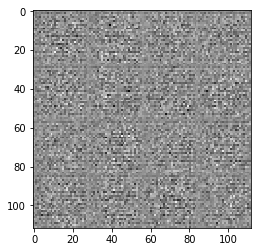

Epoch   1/  2 Batch   10 Discriminator Loss: 0.3364... Generator Loss: 7.4817
Epoch   1/  2 Batch   20 Discriminator Loss: 0.3856... Generator Loss: 7.1121
Epoch   1/  2 Batch   30 Discriminator Loss: 0.3301... Generator Loss: 7.6755
Epoch   1/  2 Batch   40 Discriminator Loss: 0.3361... Generator Loss: 7.8974
Epoch   1/  2 Batch   50 Discriminator Loss: 0.3355... Generator Loss: 7.8880
Epoch   1/  2 Batch   60 Discriminator Loss: 0.3329... Generator Loss: 8.2378
Epoch   1/  2 Batch   70 Discriminator Loss: 0.3308... Generator Loss: 8.2454
Epoch   1/  2 Batch   80 Discriminator Loss: 0.3278... Generator Loss: 8.4766
Epoch   1/  2 Batch   90 Discriminator Loss: 0.3465... Generator Loss: 8.3939
Epoch   1/  2 Batch  100 Discriminator Loss: 0.3355... Generator Loss: 8.6642


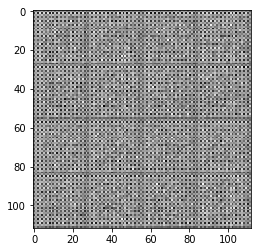

Epoch   1/  2 Batch  110 Discriminator Loss: 0.3257... Generator Loss: 8.9391
Epoch   1/  2 Batch  120 Discriminator Loss: 0.3262... Generator Loss: 9.0950
Epoch   1/  2 Batch  130 Discriminator Loss: 0.3263... Generator Loss: 9.1421
Epoch   1/  2 Batch  140 Discriminator Loss: 0.3302... Generator Loss: 9.2265
Epoch   1/  2 Batch  150 Discriminator Loss: 0.3298... Generator Loss: 9.3957
Epoch   1/  2 Batch  160 Discriminator Loss: 0.3264... Generator Loss: 9.5253
Epoch   1/  2 Batch  170 Discriminator Loss: 0.3307... Generator Loss: 9.4286
Epoch   1/  2 Batch  180 Discriminator Loss: 0.3256... Generator Loss: 9.4720
Epoch   1/  2 Batch  190 Discriminator Loss: 0.3267... Generator Loss: 9.7512
Epoch   1/  2 Batch  200 Discriminator Loss: 0.3276... Generator Loss: 9.7211


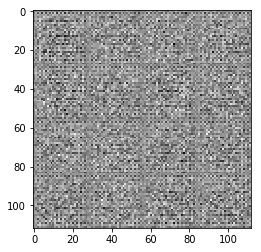

Epoch   1/  2 Batch  210 Discriminator Loss: 0.3267... Generator Loss: 9.8260
Epoch   1/  2 Batch  220 Discriminator Loss: 0.3284... Generator Loss: 10.0221
Epoch   1/  2 Batch  230 Discriminator Loss: 0.3280... Generator Loss: 9.9275
Epoch   1/  2 Batch  240 Discriminator Loss: 0.3254... Generator Loss: 9.9842
Epoch   1/  2 Batch  250 Discriminator Loss: 0.3264... Generator Loss: 9.9246
Epoch   1/  2 Batch  260 Discriminator Loss: 0.3266... Generator Loss: 9.9354
Epoch   1/  2 Batch  270 Discriminator Loss: 0.3299... Generator Loss: 10.1719
Epoch   1/  2 Batch  280 Discriminator Loss: 0.3271... Generator Loss: 10.1300
Epoch   1/  2 Batch  290 Discriminator Loss: 0.3274... Generator Loss: 10.2611
Epoch   1/  2 Batch  300 Discriminator Loss: 0.3274... Generator Loss: 10.3867


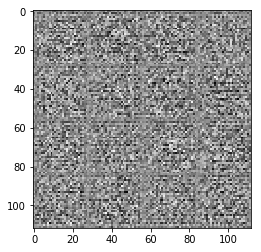

Epoch   1/  2 Batch  310 Discriminator Loss: 0.3288... Generator Loss: 10.4061
Epoch   1/  2 Batch  320 Discriminator Loss: 0.3258... Generator Loss: 10.1773
Epoch   1/  2 Batch  330 Discriminator Loss: 0.3253... Generator Loss: 10.4036
Epoch   1/  2 Batch  340 Discriminator Loss: 0.3279... Generator Loss: 10.5191
Epoch   1/  2 Batch  350 Discriminator Loss: 0.3256... Generator Loss: 10.5057
Epoch   1/  2 Batch  360 Discriminator Loss: 0.3284... Generator Loss: 10.5299
Epoch   1/  2 Batch  370 Discriminator Loss: 0.3278... Generator Loss: 10.6552
Epoch   1/  2 Batch  380 Discriminator Loss: 0.3269... Generator Loss: 10.5209
Epoch   1/  2 Batch  390 Discriminator Loss: 0.3271... Generator Loss: 10.6171
Epoch   1/  2 Batch  400 Discriminator Loss: 0.3253... Generator Loss: 10.7212


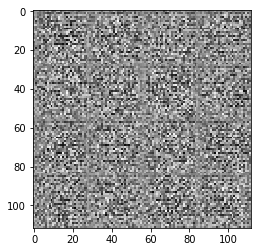

Epoch   1/  2 Batch  410 Discriminator Loss: 0.3263... Generator Loss: 10.6235
Epoch   1/  2 Batch  420 Discriminator Loss: 0.3254... Generator Loss: 10.5669
Epoch   1/  2 Batch  430 Discriminator Loss: 0.3261... Generator Loss: 10.7837
Epoch   1/  2 Batch  440 Discriminator Loss: 0.3266... Generator Loss: 10.7990
Epoch   1/  2 Batch  450 Discriminator Loss: 0.3262... Generator Loss: 10.8740
Epoch   1/  2 Batch  460 Discriminator Loss: 0.3269... Generator Loss: 10.9980
Epoch   1/  2 Batch  470 Discriminator Loss: 0.3258... Generator Loss: 10.9465
Epoch   1/  2 Batch  480 Discriminator Loss: 0.3260... Generator Loss: 11.0893
Epoch   1/  2 Batch  490 Discriminator Loss: 0.3253... Generator Loss: 10.9072
Epoch   1/  2 Batch  500 Discriminator Loss: 0.3296... Generator Loss: 11.4094


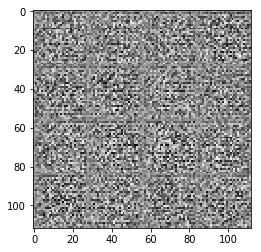

Epoch   1/  2 Batch  510 Discriminator Loss: 0.3253... Generator Loss: 11.0826
Epoch   1/  2 Batch  520 Discriminator Loss: 0.3254... Generator Loss: 10.9491
Epoch   1/  2 Batch  530 Discriminator Loss: 0.3269... Generator Loss: 11.2238
Epoch   1/  2 Batch  540 Discriminator Loss: 0.3254... Generator Loss: 10.9193
Epoch   1/  2 Batch  550 Discriminator Loss: 0.3269... Generator Loss: 11.1680
Epoch   1/  2 Batch  560 Discriminator Loss: 0.3260... Generator Loss: 11.3239
Epoch   1/  2 Batch  570 Discriminator Loss: 0.3278... Generator Loss: 11.4188
Epoch   1/  2 Batch  580 Discriminator Loss: 0.3260... Generator Loss: 11.3913
Epoch   1/  2 Batch  590 Discriminator Loss: 0.3252... Generator Loss: 11.2051
Epoch   1/  2 Batch  600 Discriminator Loss: 0.3256... Generator Loss: 11.3253


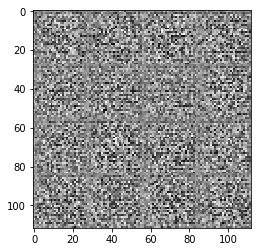

Epoch   1/  2 Batch  610 Discriminator Loss: 0.3255... Generator Loss: 11.4598
Epoch   1/  2 Batch  620 Discriminator Loss: 0.3273... Generator Loss: 11.2994


KeyboardInterrupt: 

In [36]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
show_every_n_batches = 10

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
show_every_n_batches = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.